In [8]:
# install libriaries
# %pip install tensorflow keras opencv-python matplotlib seaborn scikit-learn numpy pandas tqdm

In [9]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

# print("Path to dataset files:", path)

In [ ]:
# import libraries
import os
import time
import random
import cv2 as cv
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import pyttsx3
import threading
from tensorflow.keras.preprocessing.image import img_to_array

In [11]:
# initialize list for images and label
data_train = "Face Expression Recognition Dataset/train/"
data_test = "Face Expression Recognition Dataset/test/"

# List for arrays
X_train = []
y_train = []
folders = ["surprise", "disgust", "happy", "sad", "fear", "neutral", "angry"]


In [12]:
# Load and append dataset for preprocessing
# Train folder
for folder in folders:
    train_path = data_train + folder
    print("\nCurrent folder:", train_path)
    for current_img in tqdm(os.listdir(train_path)):
        
        try:
            # Read and convert image to Grayscale
            img = cv.imread(train_path + "/" + current_img, cv.IMREAD_GRAYSCALE)
            
            # Display image
            # cv.imshow(f"Original Image {current_img}", img)
            # cv.waitKey(1000)
            
            # resize images
            img = cv.resize(img, (48, 48))
            
            # Show resized imaage
            # cv.imshow(f"Resized Image {current_img}", img)
            # cv.waitKey(1000)
            # cv.destroyAllWindows()
            
            X_train.append(img)
            y_train.append(folder)
            
        except:
            print(f"Error loading: {img}")
        
    print("Appended all images in '{}' folder successfully.".format(folder))
    
print(f"\nFinished processing all images in the folders successfully.")



Current folder: Face Expression Recognition Dataset/train/surprise


100%|██████████| 3991/3991 [00:13<00:00, 292.60it/s]


Appended all images in 'surprise' folder successfully.

Current folder: Face Expression Recognition Dataset/train/disgust


100%|██████████| 537/537 [00:00<00:00, 1009.20it/s]


Appended all images in 'disgust' folder successfully.

Current folder: Face Expression Recognition Dataset/train/happy


100%|██████████| 3865/3865 [00:28<00:00, 134.22it/s]


Appended all images in 'happy' folder successfully.

Current folder: Face Expression Recognition Dataset/train/sad


100%|██████████| 3980/3980 [00:24<00:00, 162.07it/s]


Appended all images in 'sad' folder successfully.

Current folder: Face Expression Recognition Dataset/train/fear


100%|██████████| 3726/3726 [00:31<00:00, 119.66it/s]


Appended all images in 'fear' folder successfully.

Current folder: Face Expression Recognition Dataset/train/neutral


100%|██████████| 3978/3978 [00:32<00:00, 121.64it/s]


Appended all images in 'neutral' folder successfully.

Current folder: Face Expression Recognition Dataset/train/angry


100%|██████████| 3890/3890 [00:22<00:00, 175.48it/s]

Appended all images in 'angry' folder successfully.

Finished processing all images in the folders successfully.


In [13]:
# Convert to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

In [14]:
# Confirm length and splt into test and train
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=32)
print("\nShape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (19173, 48, 48)
Shape of y_train: (19173,)
Shape of X_test: (4794, 48, 48)
Shape of y_test: (4794,)


In [15]:
# Reshape and normalize
X_train = X_train.reshape(-1, 48, 48, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 48, 48, 1).astype('float32') / 255.0

In [16]:
# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

class_names = encoder.classes_
print("\nClasses:", class_names)

# Perform one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [17]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

In [18]:
"""Start building model"""
model = Sequential()

# First layer
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second layer 
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third layer 
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Fully connected layer 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))


# Output layer
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile with label smoothing
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

/home/wills/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-09 12:14:54.933039: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [19]:
print("Model Summary on version 1:")
model.summary()

Model Summary on version 1:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,472,711 (9.43 MB)

 Trainable params: 2,471,815 (9.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [20]:
# Callbacks
callbacks = [
    ModelCheckpoint("emotions_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

In [21]:
# # Use augementation with training
# history = model.fit(
#     datagen.flow(X_train, y_train, batch_size=32),
#     validation_data=(X_test, y_test),
#     epochs=25,
#     callbacks=callbacks,
#     verbose=1
# )

NameError: name 'history' is not defined

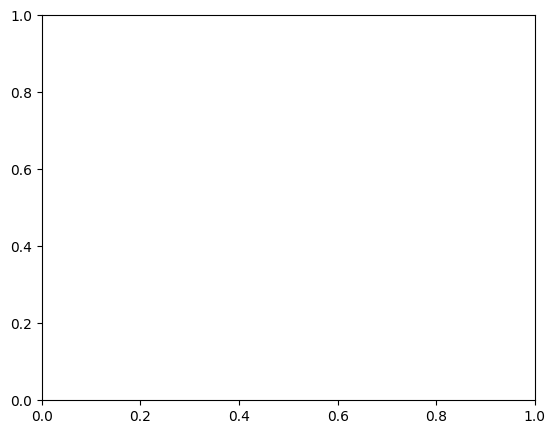

In [22]:
# Metrics graphs
plt.figure(figsize=(14,5))

# plot accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


2025-08-09 12:16:24.147795: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44181504 exceeds 10% of free system memory.


150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.5423 - loss: 1.3885

Test Accuracy: 54.69%


2025-08-09 12:16:36.656029: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44181504 exceeds 10% of free system memory.


150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step
Classification Report:

              precision    recall  f1-score   support

       angry       0.46      0.57      0.50       789
     disgust       0.00      0.00      0.00       104
        fear       0.34      0.14      0.19       747
       happy       0.78      0.75      0.76       786
     neutral       0.47      0.64      0.54       792
         sad       0.44      0.39      0.41       778
    surprise       0.69      0.84      0.76       798

    accuracy                           0.55      4794
   macro avg       0.45      0.48      0.45      4794
weighted avg       0.52      0.55      0.52      4794



/home/wills/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wills/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wills/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


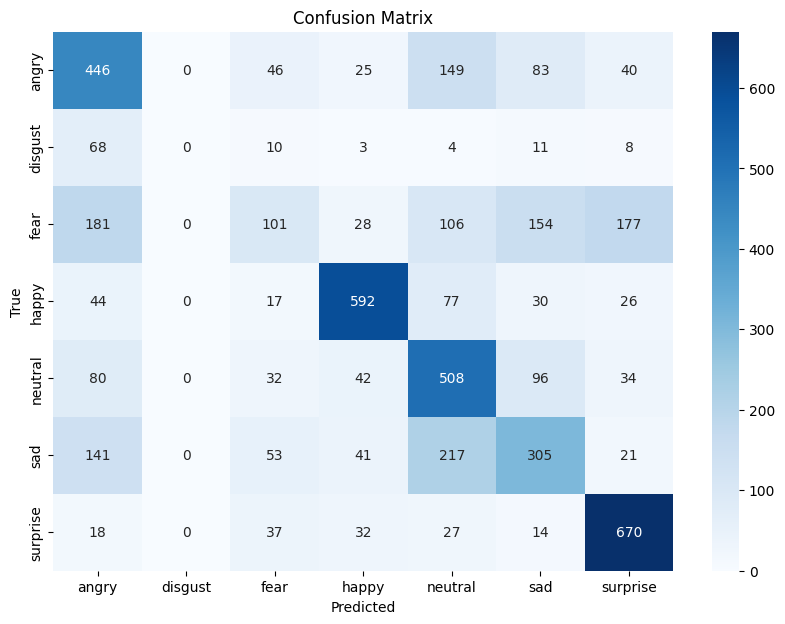

In [24]:
#load model and predict
model = load_model("emotions_model.h5")

#Evaluation on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

#Predict labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


# classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

# plot confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

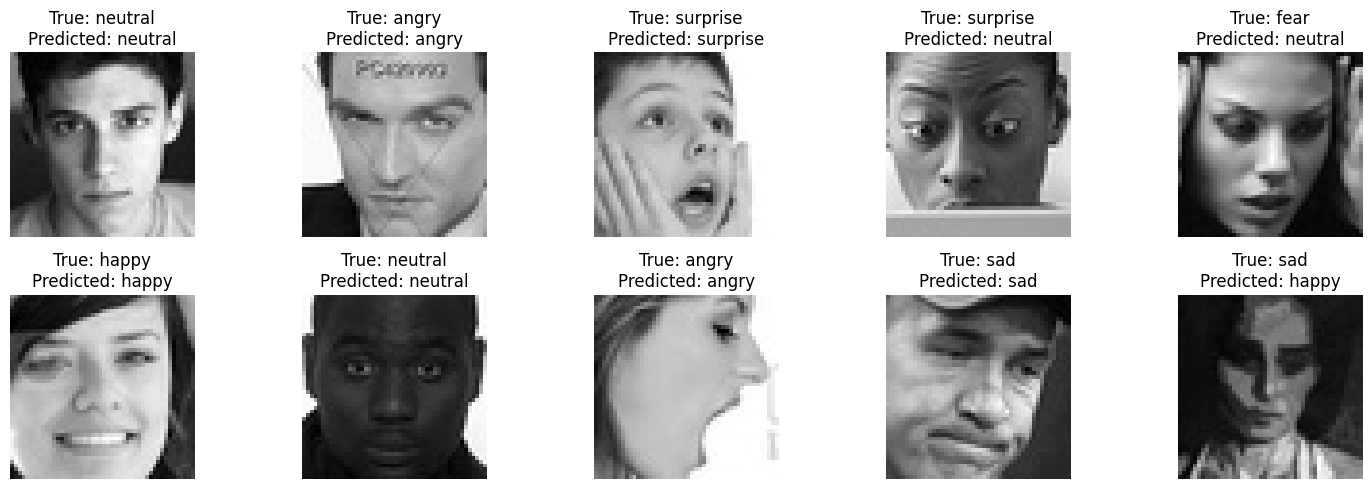

In [ ]:
# Display 10 random test images with predicted and actual emotions
plt.figure(figsize=(15, 5))
for i in range(10):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx].reshape(48, 48)
    true_label = encoder.classes_[y_true[idx]]
    pred_label = encoder.classes_[y_pred_classes[idx]]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPredicted: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    data_test,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical'
)

Found 70 images belonging to 7 classes.


In [25]:
def predict_emotion(img_path):
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    if img is None:
        print("Error: File not found. Check the path or file format.")
        return None

    img = cv.resize(img, (48, 48))
    img = img.reshape(1, 48, 48, 1) / 255.0

    prediction = model.predict(img)
    
    # Directly hardcoded class labels
    class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    predicted_label = class_labels[np.argmax(prediction)]

    return predicted_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


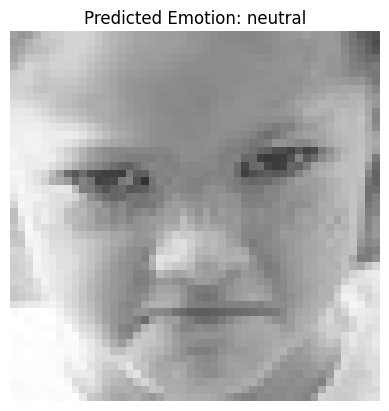

In [27]:
def show_image_with_prediction(img_path):
    emotion = predict_emotion(img_path)
    if emotion:
        img = cv.imread(img_path)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(f"Predicted Emotion: {emotion}")
        plt.axis('off')
        plt.show()

# Use it:
show_image_with_prediction("Face Expression Recognition Dataset/test/angry/angry_test_03.jpg")


In [50]:
# Load emotion detection model
model = load_model("emotions_model.h5")
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Initialize TTS
engine = pyttsx3.init()
engine.setProperty('rate', 160)

# Function to run speech in background
def speak_emotion(emotion):
    def _speak():
        if emotion_labels == "Fear":
            engine.say(f"You look {emotion.lower()}ful")  # fearful
        elif emotion_labels == "Surprise":
            engine.say(f"You look {emotion.lower()}d")    # surprised
        else:
            engine.say(f"You look {emotion.lower()}")
        engine.runAndWait()
        
    threading.Thread(target=_speak, daemon=True).start()


# Haar Cascade for face detection
face_classifier = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")

# Video capture
cap = cv.VideoCapture(0)

last_spoken_time = 0
speak_interval = 7  # 7 seconds
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    #flip video output horizontally
    frame = cv.flip(frame, 1)
    
    # Convert to grayscale
    frame2gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_classifier.detectMultiScale(frame2gray, scaleFactor=1.2, minNeighbors=4)

    for (x, y, w, h) in faces:
        roi = frame2gray[y:y+h, x:x+w]
        roi_resized = cv.resize(roi, (48, 48))
        roi_normalized = roi_resized / 255.0
        roi_reshaped = np.reshape(roi_normalized, (1, 48, 48, 1))

        # Prediction
        prediction = model.predict(roi_reshaped, verbose=0)
        emotion_index = np.argmax(prediction)
        predicted_emotion = emotion_labels[emotion_index]
        confidence = np.max(prediction) * 100

        # Draw rectangle around face
        color = (0, 255, 0) if predicted_emotion == 'Happy' else (255, 0, 0)
        cv.rectangle(frame, (x, y), (x + w, y + h), color, 2)

        label = f"{predicted_emotion} ({confidence:.1f}%)"
        cv.putText(frame, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        # Speak if detected another emotion
        current_time = time.time()
        if (predicted_emotion != last_spoken_emotion) or (current_time - last_spoken_time > speak_interval):
            speak_emotion(predicted_emotion)
            last_spoken_emotion = predicted_emotion
            last_spoken_time = current_time
            
            
    cv.imshow('Emotion Detection', frame)

    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()
